In [1]:
%matplotlib inline
import torch

from PIL import Image
import numpy as np

import cv2
import matplotlib.pyplot as plt
from torchray.attribution.grad_cam import grad_cam as tr_gradcam

import torch.nn.functional as F
import torch.nn as nn
import torchvision
from torchvision import transforms
import PIL
from omegaconf import OmegaConf
from tqdm import tqdm

import os
if os.getcwd().split(os.sep)[-1] == 'notebooks':
    os.chdir('..')
print(os.getcwd())

import matplotlib
matplotlib.rcParams.update({'font.size': 18})

from utils.rise import RISE
from models.resnet import resnet18, resnet50
import utils.general_utils as gu
from datasets import normalizations
import datasets

/home/spetryk/vl-attention


In [11]:
def load_checkpoint(checkpoint_file, net):
    checkpoint = torch.load(checkpoint_file, map_location='cpu')
    state_dict = gu.check_module_state_dict(checkpoint['model_state_dict'])
    net.load_state_dict(state_dict)
    print('Loaded checkpoint {}'.format(checkpoint_file))

    
    
    
def plot(numpy_image, label_float, prob_float, attention, label_mapping=None, save_path=None):
    if label_mapping is not None:
        cls = label_mapping[int(label_float)]
    else:
        cls = 'Class {}'.format(int(label_float))

    fig, ax = plt.subplots(1,2, figsize=(5,6))
    ax[0].imshow(numpy_image)
    ax[0].axis('off')

    ax[1].imshow(numpy_image)
    ax[1].imshow(attention, alpha=0.4, cmap='jet')
    ax[1].axis('off')
    ax[1].set_title('{}: {:.3f}'.format(cls, prob_float),
                    fontsize=14)

    plt.tight_layout()
    if save_path is not None:
        plt.savefig(save_path, bbox_inches='tight')
    else:
        plt.show()
    return



class RISENet(nn.Module):
    def __init__(self, net, num_classifier_classes=1):
        super(RISENet, self).__init__()
        self.net = net
        self.num_classifier_classes = num_classifier_classes
        
        if num_classifier_classes == 1:
            self.activation = nn.Sigmoid()
        else:
            self.activation = nn.Softmax(dim=1)
        
    def forward(self, inputs):
        logits = self.net(inputs)
        probs, _, _ = gu.calc_preds(logits, self.activation, self.num_classifier_classes)
        return probs
    



In [9]:
config_file = 'configs/waterbirds_generic.yaml'
cfg       = OmegaConf.load(config_file)
base_cfg  = OmegaConf.load('configs/base.yaml')
args      = OmegaConf.merge(base_cfg, cfg)

size = args.DATA.SIZE

device = 'cuda:2'
model_type = args.EXP.MODEL


In [84]:
# Just a sample
checkpoint = 'wandb/buggy_balanced_val_waterbirds/wandb/run-20210523_162425-clip_r50_rrr_bs96/files/best_balanced_valacc_0.87_epoch_194.ckpt'
num_classifier_classes = 1
num_classes = 2

if model_type == 'resnet50':
    net = resnet50(pretrained=False, num_classes = num_classifier_classes)
else:
    net = resnet18(pretrained=False, num_classes = num_classifier_classes)
    
    
#net.to(device)
os.environ['CUDA_VISIBLE_DEVICES'] = ''
load_checkpoint(checkpoint, net)

# Add activation
net = RISENet(net, num_classifier_classes)
net.to(device)
net.eval()
    

Loaded checkpoint wandb/buggy_balanced_val_waterbirds/wandb/run-20210523_162425-clip_r50_rrr_bs96/files/best_balanced_valacc_0.87_epoch_194.ckpt


RISENet(
  (net): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0):

In [5]:
device = 'cuda:2'
net = resnet50(pretrained=True)
    
#net.to(device)
#os.environ['CUDA_VISIBLE_DEVICES'] = '2'

# Add activation
num_classifier_classes = 1000
num_classes = 1000
size = 224

net = RISENet(net, num_classifier_classes)
net.to(device)
net.eval()

RISENet(
  (net): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0):

In [34]:
# ***** Set dataset *****
dataset_type = args.DATA.DATASET
print(dataset_type)
if dataset_type == 'waterbirds':
    from datasets.waterbirds import Waterbirds as Dataset
    label_mapping = datasets.waterbirds.get_label_mapping()
elif dataset_type == 'coco_gender':
    from datasets.coco import COCOGender as Dataset
elif dataset_type == 'coco_device':
    from datasets.coco_device import COCODevice as Dataset
else:
    raise NotImplementedError

mean, std = normalizations.normalizations['imagenet']['mean'], \
            normalizations.normalizations['imagenet']['std']
transform = transforms.Compose([
    transforms.Resize((size, size)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

test_dataset = Dataset(root='./data',
                       cfg=args,
                       transform=transform,
                       split='test')

test_dataloader = torch.utils.data.DataLoader(test_dataset,
                                              batch_size=1,
                                              num_workers=args.DATA.NUM_WORKERS,
                                              shuffle=False)




waterbirds
WATERBIRDS DIR: ./data/waterbird_complete95_forest2water2


In [6]:
# RISE setup
rise = RISE(net,
            (size, size),
            num_classes=num_classes,
            gpu_batch=16,
            p1=0.1)
# Generate masks for RISE or use the saved ones.
maskspath = 'masks.npy'
generate_new = True
rise_N = 100
rise_s = 8
if generate_new or not os.path.isfile(maskspath):
    rise.generate_masks(N=rise_N, s=rise_s, device=device, savepath=maskspath)
else:
    rise.load_masks(maskspath, device)
    print('Masks are loaded.')
name = 'rise_N_{}_s_{}'.format(rise_N, rise_s)# if generate_new else 'rise_used_old_masks'



Generating filters: 100%|██████████| 100/100 [00:00<00:00, 229.52it/s]


  0%|          | 0/5794 [00:00<?, ?it/s]

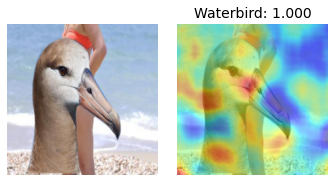

  0%|          | 1/5794 [00:03<5:15:38,  3.27s/it]

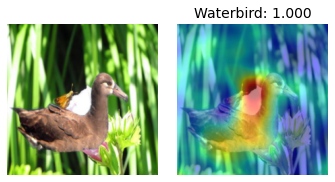

  0%|          | 2/5794 [00:05<4:58:12,  3.09s/it]

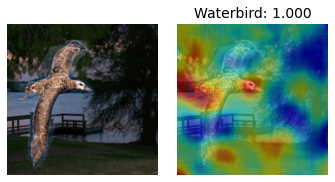

  0%|          | 3/5794 [00:08<4:46:37,  2.97s/it]

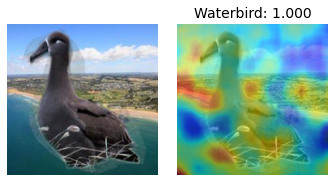

  0%|          | 4/5794 [00:11<4:38:55,  2.89s/it]

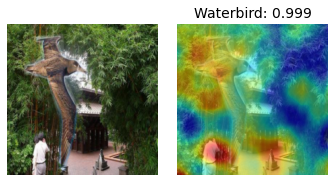

  0%|          | 5/5794 [00:14<4:33:20,  2.83s/it]

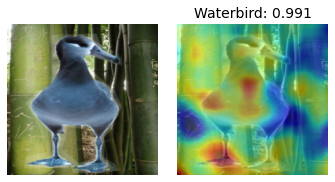

  0%|          | 5/5794 [00:17<5:31:23,  3.43s/it]


In [87]:
net.eval()
torch.set_grad_enabled(False)
for i, batch in enumerate(tqdm(test_dataloader)):
    inputs, labels = batch['image'].to(device), batch['label'].to(device)
    
    img_path = batch['image_path'][0]
    pil_image =  transforms.Resize((size, size))(Image.open(img_path).convert('RGB'))
    numpy_image = np.array(pil_image)
    
    saliencies = rise(inputs)
    
    probs  = net(inputs) # 1 x num_classes
    

    prob_float = float(model_out[0][labels[0].long()].cpu())
    label_float = float(labels[0])
    
    sample_sal = saliencies[labels[0].long()].cpu().numpy() # 224 x 224
    
    plot(numpy_image,
         label_float,
         prob_float,
         sample_sal,
         label_mapping=label_mapping,
         save_path=None
    )
    
    if i == 5:
        break


def explain_all(images, labels, explainer):
    total = len(labels)
    probs, classpreds = torch.sort(nn.Softmax(1)(explainer.model(images)), dim=1, descending=True)
    explanations = []
    for img in images:
        explanations.append(explainer(torch.unsqueeze(img, 0)))
    return explanations, probs, classpreds


In [17]:
out.shape


torch.Size([1000, 224, 224])

In [18]:
labels

tensor([1.], device='cuda:2')

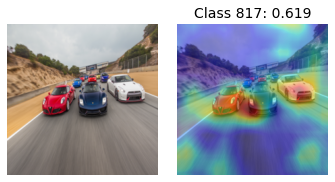

In [13]:
torch.set_grad_enabled(False)

mean, std = normalizations.normalizations['imagenet']['mean'], \
            normalizations.normalizations['imagenet']['std']
transform = transforms.Compose([
    transforms.Resize((size, size)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

img_path = 'sample_ims/cars.jpg'
pil_image =  transforms.Resize((size, size))(Image.open(img_path).convert('RGB'))
numpy_image = np.array(pil_image)

img = transform(pil_image).unsqueeze(0).to(device)


saliencies = rise(img)

probs  = net(img) # 1 x num_classes
pred_class = torch.where(probs == torch.max(probs))[1].item()


prob_float = float(probs[0][pred_class].cpu())
label_float = float(pred_class)

sample_sal = saliencies[pred_class].cpu().numpy() # 224 x 224

plot(numpy_image,
     label_float,
     prob_float,
     sample_sal,
     label_mapping=None,
     save_path=None
)

